# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


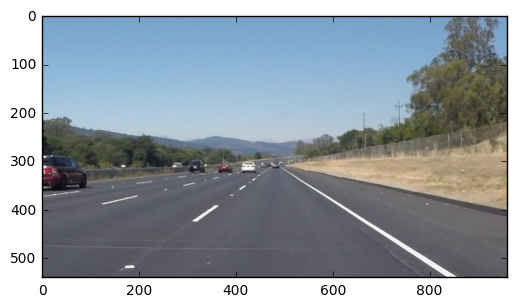

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['.ipynb_checkpoints',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [5]:
# New and Modified Helper Functions written by Mukil Kesavan

def hsv(img):
    """Converts the input image to HSV scale.
    NOTE: Please use cmap='hsv' with plt.imshow on
    the converted image"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Or use BGR2HSV if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


# Global Variables Used in the Function Below For Smoothing Lane Lines
ll_slope_frames = 0.0
rl_slope_frames = 0.0
ll_intercept_frames = 0.0
rl_intercept_frames = 0.0
nframes = 0
MIN_FRAME_SAMPLES = 3

def reset_global_variables():
    """
    Resets global variables to their correct
    value. To be called before each video
    is processed.
    """
    global ll_slope_frames
    global rl_slope_frames
    global ll_intercept_frames
    global rl_intercept_frames
    global nframes
    global MIN_FRAME_SAMPLES

    ll_slope_frames = 0.0
    rl_slope_frames = 0.0
    ll_intercept_frames = 0.0
    rl_intercept_frames = 0.0
    nframes = 0
    MIN_FRAME_SAMPLES = 3


def draw_lines_avg_slope_intercept_smoothing(img, lines, color=[255, 0, 0], thickness=10, smoothing_param = 1.0):
    """
    This computes two single lines corresponding to the
    left and right lanes based on both the current average
    slope and intercept of the input 'lines' and its historical
    value across multiple frames. It uses an exponentially
    weighted moving average filter to "smooth" out suddent changes
    in a lane line's slope on successive video frames.
    
    NOTE: Setting the smoothing_param's value to 1 disables the
    use of historical values.
    """
    global ll_slope_frames
    global rl_slope_frames
    global ll_intercept_frames
    global rl_intercept_frames
    global nframes
    global MIN_FRAME_SAMPLES
    
    avg_ll_slope = 0.0
    avg_rl_slope = 0.0
    n_ll_lines = 0.0
    n_rl_lines = 0.0
    avg_ll_intercept = 0
    avg_rl_intercept = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #Ignore horizontal lines, if any
            if (x2-x1) == 0:
                continue
            slope = (y2-y1) / (x2-x1)
            if slope < 0:
                #left lane
                avg_ll_slope += slope
                n_ll_lines += 1
                avg_ll_intercept += (y1 - slope * x1)
            elif slope > 0:
                #right lane
                avg_rl_slope += slope
                n_rl_lines += 1
                avg_rl_intercept += (y1 - slope * x1)
 
    #Ignore any images that were too dark to detect any lines
    if n_ll_lines == 0 or n_rl_lines == 0:
        return
    
    avg_ll_slope /= n_ll_lines
    avg_rl_slope /= n_rl_lines
    avg_ll_intercept /= n_ll_lines
    avg_rl_intercept /= n_rl_lines
    
    def get_smoothed_value(hist_val, cur_val):
        """
        Applies an exponentially weighted moving average filter
        as long as we have at least MIN_FRAME_SAMPLES accounted
        into our historical data so as to prevent fluctuations at
        the start.
        """
        global nframes
        global MIN_FRAME_SAMPLES
        if hist_val != 0 and nframes > MIN_FRAME_SAMPLES:
            return (cur_val * smoothing_param + hist_val * (1.0 - smoothing_param))
        return cur_val

    avg_ll_slope = ll_slope_frames = get_smoothed_value(ll_slope_frames, avg_ll_slope)
    avg_rl_slope = rl_slope_frames = get_smoothed_value(rl_slope_frames, avg_rl_slope)
    avg_ll_intercept = ll_intercept_frames = get_smoothed_value(ll_intercept_frames, avg_ll_intercept)
    avg_rl_intercept = rl_intercept_frames = get_smoothed_value(rl_intercept_frames, avg_rl_intercept)
    nframes += 1
    
    #Now that we have the smoothed average slope and intercept for
    #left and right lane lines, we simply calculate the top and
    #bottom end points, (x_b, y_b) and (x_t, y_t), of both lines
    #and have opencv draw us the lines.
   
    def determine_top_frac():
        """
        Determine the how much we should extrapolate
        lines to the top of the image such that they
        don't intersect.
        """
        for tf in np.arange(0, 1, 0.05):
            ltx = int((image.shape[1] * tf - avg_ll_intercept)/avg_ll_slope)
            rtx = int((image.shape[1] * tf - avg_rl_intercept)/avg_rl_slope)
            if (rtx - ltx) > 0:
                return tf

    #We can determine the y_t dynamically based on the slope and
    #intercept such that the extrapolated lane lines don't
    # intersect, as shown above. x_b and y_b
    #are set respectively to x-axis max and y-axis max.  
    top_frac = determine_top_frac()
    #Left Lane
    ll_bottom = (int((image.shape[1] - avg_ll_intercept)/avg_ll_slope), image.shape[1])
    ll_top = (int((image.shape[1] * top_frac - avg_ll_intercept)/avg_ll_slope), int(image.shape[1] * top_frac))
    cv2.line(img, tuple(ll_top), tuple(ll_bottom), color, thickness)
    
    #Right Lane
    rl_bottom = (int((image.shape[1] - avg_rl_intercept)/avg_rl_slope), image.shape[1])
    rl_top = (int((image.shape[1] * top_frac - avg_rl_intercept)/avg_rl_slope), int(image.shape[1] * top_frac))
    cv2.line(img, tuple(rl_top), tuple(rl_bottom), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, smoothing = 1.0):
    """
    `img` should be the output of a Canny transform.   
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_avg_slope_intercept_smoothing(line_img, lines, smoothing_param = smoothing)
    return line_img


def pick_lane_colors(hsv_img):
    """
    Pick out yellow and white lane line colors from the input image
    in HSV scale. We use HSV because it is easier to define colors
    using the Hue value compared to an RGB scale.
    """
    #Range of Yellow Colors in HSV
    YELLOW_LOW = np.array([20,100,100])
    YELLOW_HIGH = np.array([30,255,255])
    #Range of White Colors in HSV
    WHITE_LOW = np.array([0,0,230])
    WHITE_HIGH = np.array([180,255,255])

    #Threshold the HSV image to get only yellow and white colors.
    #i.e., ((yellow_mask | white_mask) & hsv_image)
    mask_y = cv2.inRange(hsv_img, YELLOW_LOW, YELLOW_HIGH)
    mask_w = cv2.inRange(hsv_img, WHITE_LOW, WHITE_HIGH)
    mask = cv2.bitwise_or(mask_y, mask_w)

    # Bitwise-AND mask and original image
    return cv2.bitwise_and(hsv_img, hsv_img, mask = mask)

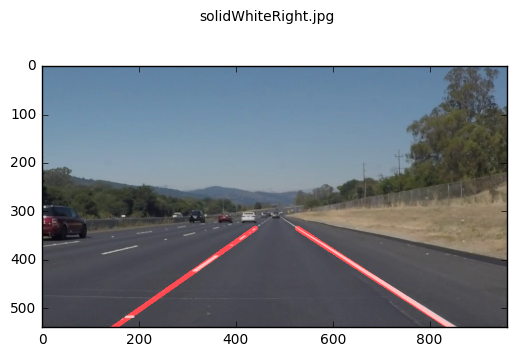

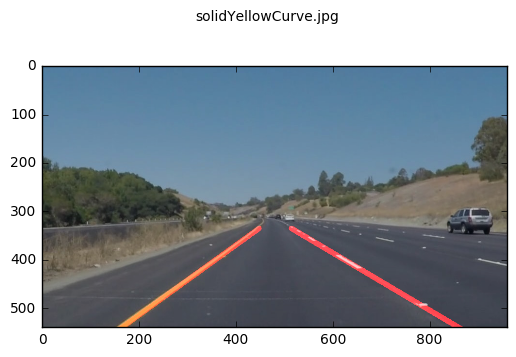

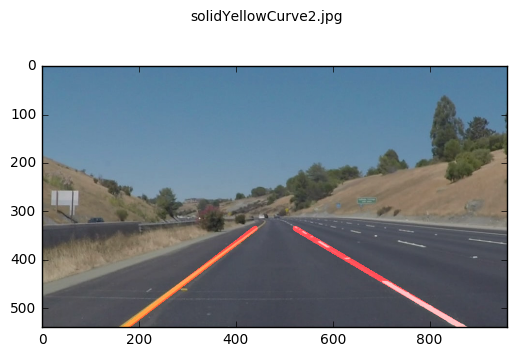

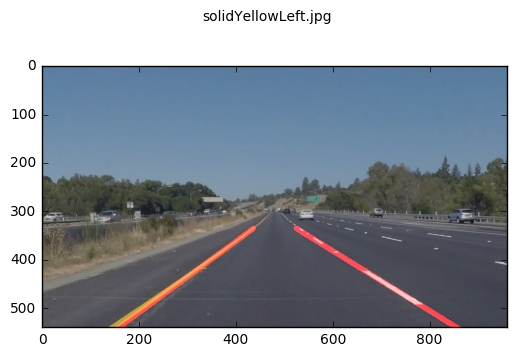

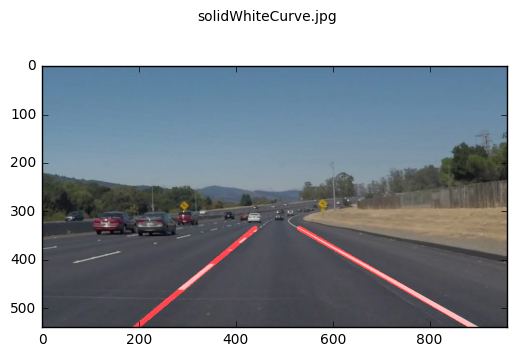

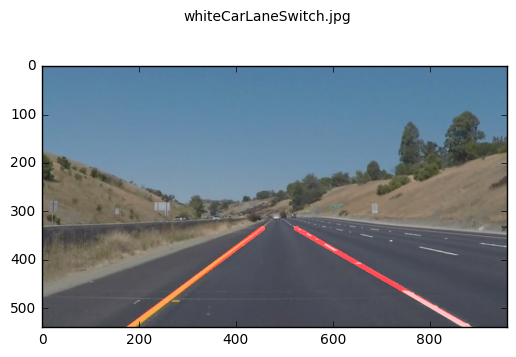

In [6]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def lane_detection_pipeline(image, smoothing_param = 1.0):
    imshape = image.shape
    #print('This image is:', type(image), 'with dimesions:', image.shape)
    
    #1. Convert Image to HSV Scale
    hsvim = hsv(image)
    #2. Pick only white and yellow shades in image corresponding to lanes
    color_masked = pick_lane_colors(hsvim)
    #3. Apply Canny edge detection
    edges = canny(color_masked, 50, 200)
    #4. Extract quadrilateral region where we expect to find lanes
    roi_vertices = np.array([[\
                      (int(imshape[1] * 0.15), int(imshape[0] * 0.9)),\
                      (int(imshape[1] * 0.45) , int(imshape[0] * 0.6)),\
                      (int(imshape[1] * 0.55), int(imshape[0] * 0.6)),\
                      (imshape[1] * 0.85, int(imshape[0] * 0.9))\
                    ]], dtype=np.int32)
    roi = region_of_interest(edges, roi_vertices)
    #5. Apply Hough transformation
    hlines = hough_lines(roi, 1, (np.pi/180), 10, 15, 3, smoothing_param)
    #6. Overlay lane lines on original image
    return weighted_img(hlines, image)

###

imgdir = "test_images/"
input_images = [ii for ii in os.listdir(imgdir) if not ii.startswith('.')]
for input_image in input_images:
    image = mpimg.imread(imgdir + input_image)
    ldimage = lane_detection_pipeline(image)
    fig = plt.figure()
    fig.suptitle(input_image)
    plt.imshow(ldimage)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = lane_detection_pipeline(image, smoothing_param = 0.15)
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
reset_global_variables()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:14<00:00, 13.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.28 s, sys: 444 ms, total: 4.73 s
Wall time: 16.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
reset_global_variables()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:47<00:00, 14.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.9 s, sys: 612 ms, total: 13.5 s
Wall time: 49.1 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

---

Here's the process I went through to get to the final videos in this notebook:

I tried out the following techniques to join lane segments after canny detection, region masking and hough transformation of a video frame:

1. Detect the left and right lane top most and bottom most (x,y) point pairs and join them in a single line for each lane.

2. For each lane, gather a series of points from all the line segments and use opencv fitLine that minimizes the squared error of points.

2. Compute the average slope and intercept of all the line segments that make up a lane and use that to draw a single lane line.

Approach 3 worked for me the best. But the lanes seem to jump around too much from frame to frame in the test videos. So I tried the following two additional techniques:

1. Limit the percentage change in slope of a lane line between each successive video frame to a tunable paramater value.

2. Use a running exponentially weighted moving average to "smooth" out sudden changes in a lane line's slope.

Approach 2 gave me the best result as shown in the video.

When I moved on to trying my pipeline on the challenge video I faced several challenges as listed below:

1. Challenge 1: Detecting lane lines against a light concrete background instead of black asphalt and also when there were shadows on the road ahead.

The grayscale image with gaussian blur applied to a video frame basically washed out the pixel intensity difference between the background and the lane lines. I tried the following two approaches to overcome the problem:

1.a. I adjusted the low and high thresholds of the Canny edge detection algorithm to pick out very little pixel intensity differences. This worked for the video frames where the lanes lines were against concrete but resulted in a lot of spurious edges for the regular case. I figured that the Canny parameters need to be determined dynamically based on the current frame. However, I did not know of a way of doing that.

1.b. I converted the image to HSV scale instead of grayscale and filtered out different shades of white and yellow pixels and applied Canny edge detection on the resultant image with the same thresholding parameters used for all the other videos.

Approach 1.b gave me the best result. However, I realize that this approach may not work ideally when the lane lines are or appear to be of different colors due to environmental conditions (such as night or the presence of snow etc.). On browsing the facebook page for the December 2016 class, I learned of two possible techniques that could be used to deal with this problem: (i) Random Sampling Consensus (RANSAC) and (ii) Kalman Filtering. I spent some time learning about the intuition behind both of those techniques so that I might be able to use it in a future project.

2. Challenge 2: Lanes with high curvature

On image frames where the lanes had high curvature, the extrapolated straight lane lines appearing somewhat tangential to the curvature of the actual lane line. Some of these artifacts could perhaps be seen in my output for the challenge video. The only option I could think of was to perhaps fit a curve with higher order polynomials intead of a straight line. I did not have time to fix this by the project deadline.

---

Overall, this was a very fun project. I learnt the importance of not overfitting my models, several computer vision processing and noise reduction techniques.

- Mukil Kesavan (December 2016 Class)

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
reset_global_variables()
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:35<00:00,  6.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 8.37 s, sys: 1.59 s, total: 9.96 s
Wall time: 38.8 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))